The roll_landbaseyear tells us when the land value was last updated.
The properties with roll_landbaseyear 2021 are the up to date land values

In [2]:
import pandas as pd
import psycopg2
import os

# read data from local psql database into pd dataframe
try:
    conn = psycopg2.connect(database='parcelDatabase', user=os.getenv(
        "USER"), password=os.getenv("PASSWORD"))
    print("successfully connected to database")
except:
    print("I am unable to connect to the database")
df = pd.read_sql_query('select * from "rawparceltable"', con=conn)

print(df.head())


successfully connected to database
          ain situszip usecodedescchar1 sqftmain roll_landvalue  \
0  6079023009                Commercial        0        1656272   
1  5378020023                Commercial        0           5652   
2  5006006008                Commercial        0           1085   
3  8178001040                Commercial        0           9955   
4  6024009001                Commercial        0           3155   

  roll_landbaseyear istaxableparcel   center_lat     center_lon  
0              2011               Y                              
1              1975               Y  34.13765976  -118.07028189  
2              2007               Y  33.99332974  -118.33164086  
3              1997               Y  33.97044155  -118.07249959  
4              1986               Y  33.97138846  -118.25606768  


Format column types from default string

In [3]:
# convert columns of df to numeric
numeric_cols = ["roll_landbaseyear", "center_lat",
                "center_lon", "roll_landvalue", "sqftmain"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)


Getting distribution of land base roll year: a little over 2500 of the parcel values have been updated in the last year (total 50k values)

# of parcels updated in 2020:  234
# of parcels updated in 2021:  59
total # of parcels in table:  65761


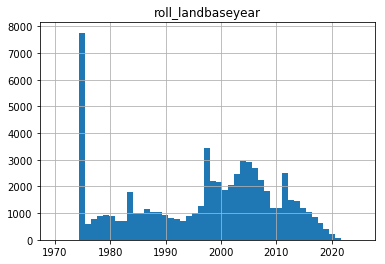

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df.hist(column="roll_landbaseyear", range=[1970, 2025], bins=51)

df_updated_2020 = df[df["roll_landbaseyear"] == 2020]
df_updated_2021 = df[df["roll_landbaseyear"] == 2021]

print("# of parcels updated in 2020: ", len(df_updated_2020))
print("# of parcels updated in 2021: ", len(df_updated_2021))
print("total # of parcels in table: ", len(df))


feed as input into SVR model

Reference:
https://towardsdatascience.com/support-vector-regression-svr-one-of-the-most-flexible-yet-robust-prediction-algorithms-4d25fbdaca60

In [5]:
# split data into test and train
from sklearn.model_selection import train_test_split

drop_cols = ['istaxableparcel', 'usecodedescchar1']
df = df.drop(drop_cols, 1)

train, test = train_test_split(df, test_size=0.2)

In [6]:
# for building a linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR  # for building support vector regression model
import plotly.graph_objects as go  # for data visualization
import plotly.express as px  # for data visualization

# Create a scatter plot
fig = px.scatter(df, x=df['sqftmain'], y=df['roll_landvalue'],
                 opacity=0.8, color_discrete_sequence=['black'])

# Change chart background color
fig.update_layout(dict(plot_bgcolor='white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
                 showline=True, linewidth=1, linecolor='black')

# Set figure title
fig.update_layout(title=dict(text="Sale Prices based on sqft",
                             font=dict(color='black')))

# Update marker size
fig.update_traces(marker=dict(size=3))

fig.show()


SVR fitting

In [7]:
# ------- Select variables -------
# Note, we need X to be a 2D array, hence reshape
X = df['sqftmain'].values.reshape(-1, 1)
y = df['roll_landvalue'].values

# ------- Linear regression -------
model1 = LinearRegression()
lr = model1.fit(X, y)

# ------- Support Vector regression -------
model2 = SVR(kernel='rbf', C=1, epsilon=10)  # set kernel and hyperparameters
svr = model2.fit(X, y)

# ------- Predict a range of values based on the models for visualization -------
# Create 100 evenly spaced points from smallest X to largest X
x_range = np.linspace(X.min(), X.max(), 100)

# Predict y values for our set of X values
y_lr = model1.predict(x_range.reshape(-1, 1))  # Linear regression
y_svr = model2.predict(x_range.reshape(-1, 1))  # SVR


visualize the two models

In [8]:
# Create a scatter plot
fig = px.scatter(df, x=df['sqftmain'], y=df['roll_landvalue'],
                 opacity=0.8, color_discrete_sequence=['black'])

# Add a best-fit line
fig.add_traces(go.Scatter(x=x_range, y=y_lr,
                          name='Linear Regression', line=dict(color='limegreen')))
fig.add_traces(go.Scatter(x=x_range, y=y_svr,
                          name='Support Vector Regression', line=dict(color='red')))
fig.add_traces(go.Scatter(x=x_range, y=y_svr + 10,
                          name='+epsilon', line=dict(color='red', dash='dot')))
fig.add_traces(go.Scatter(x=x_range, y=y_svr - 10,
                          name='-epsilon', line=dict(color='red', dash='dot')))

# Change chart background color
fig.update_layout(dict(plot_bgcolor='white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
                 showline=True, linewidth=1, linecolor='black')

# Set figure title
fig.update_layout(title=dict(text="Sale Price based on Sqft with Model Predictions (epsilon=10, C=1)",
                             font=dict(color='black')))
# Update marker size
fig.update_traces(marker=dict(size=3))

fig.show()


3D scatter plot based on both sqft and roll year (last updated year)

In [9]:

# Create a 3D scatter plot
fig = px.scatter_3d(df, x=df['sqftmain'], y=df['roll_landbaseyear'], z=df['roll_landvalue'],
                    opacity=0.8, color_discrete_sequence=['black'])

# Set figure title
fig.update_layout(title_text="Scatter 3D Plot",
                  scene=dict(xaxis=dict(backgroundcolor='white',
                                        color='black',
                                        gridcolor='lightgrey'),
                             yaxis=dict(backgroundcolor='white',
                                        color='black',
                                        gridcolor='lightgrey'
                                        ),
                             zaxis=dict(backgroundcolor='white',
                                        color='black',
                                        gridcolor='lightgrey')))

# Update marker size
fig.update_traces(marker=dict(size=3))

fig.show()


Training the SVR model on sqft and roll year

We use the following hyperparameters for the SVR model: epsilon = 1, C = 100. These parameters are not ideal for this model. We should train and test multiple versions of the model to identify more optimal hyperparameter values.


In [10]:
# ----------- Select variables -----------
X = df[['sqftmain', 'roll_landbaseyear']]
y = df['roll_landvalue'].values

# ----------- Model fitting -----------
# Define models and set hyperparameter values
model1 = LinearRegression()
model2 = SVR(kernel='rbf', C=100, epsilon=1)

# Fit the two models
lr = model1.fit(X, y)
svr = model2.fit(X, y)

# ----------- For creating a prediciton plane to be used in the visualization -----------
# Set Increments between points in a meshgrid
mesh_size = 1

# Identify min and max values for input variables
x_min, x_max = X['sqftmain'].min(
), X['sqftmain'].max()
y_min, y_max = X['roll_landbaseyear'].min(), X['roll_landbaseyear'].max()

# Return evenly spaced values based on a range between min and max
xrange = np.arange(x_min, x_max, mesh_size)
yrange = np.arange(y_min, y_max, mesh_size)

# Create a meshgrid
xx, yy = np.meshgrid(xrange, yrange)

# ----------- Create a prediciton plane  -----------
# Use models to create a prediciton plane --- Linear Regression
pred_LR = model1.predict(np.c_[xx.ravel(), yy.ravel()])
pred_LR = pred_LR.reshape(xx.shape)

# Use models to create a prediciton plane --- SVR
pred_svr = model2.predict(np.c_[xx.ravel(), yy.ravel()])
pred_svr = pred_svr.reshape(xx.shape)

# Note, .ravel() flattens the array to a 1D array,
# then np.c_ takes elements from flattened xx and yy arrays and puts them together,
# this creates the right shape required for model input

# prediction array that is created by the model output is a 1D array,
# Hence, we need to reshape it to be the same shape as xx or yy to be able to display it on a graph
